In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Veri setini yükleme
df = pd.read_csv('/Users/emin/Desktop/Biyoinformatik/dataset.csv')

# Sleep Disorder sütunundaki boş değerleri 'None' stringi ile dolduralım
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# İlk 5 satırı görüntüleme
print("Veri Setinin İlk 5 Satırı:")
print(df.head())

print("\nVeri Seti Bilgileri:")
print(df.info())

Veri Setinin İlk 5 Satırı:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200           None  
1      

In [35]:
# Kan Basıncını Ayrıştırma
if 'Blood Pressure' in df.columns:
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
    df['Systolic_BP'] = df['Systolic_BP'].astype(int)
    df['Diastolic_BP'] = df['Diastolic_BP'].astype(int)
    df = df.drop(columns=['Blood Pressure'])

# Uyku Bozukluklarını Ayrıştırma (GELİŞMİŞ ANALİZ)
# Basit 0,1,2 kodlaması yerine, her hastalık için ayrı 1/0 sütunları oluşturuyoruz.
# Bu sayede korelasyon analizi çok daha doğru sonuç verecektir.

# 1. Insomnia Varlığı
df['Has_Insomnia'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)

# 2. Uyku Apnesi Varlığı
df['Has_Sleep_Apnea'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Sleep Apnea' else 0)

# 3. Herhangi Bir Bozukluk Varlığı (None olmayanlar)
df['Has_Any_Disorder'] = df['Sleep Disorder'].apply(lambda x: 0 if x == 'None' else 1)

print("\nYeni Hastalık Gösterge Sütunları Eklendi:")
print(df[['Sleep Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder']].head())


Yeni Hastalık Gösterge Sütunları Eklendi:
  Sleep Disorder  Has_Insomnia  Has_Sleep_Apnea  Has_Any_Disorder
0           None             0                0                 0
1           None             0                0                 0
2           None             0                0                 0
3    Sleep Apnea             0                1                 1
4    Sleep Apnea             0                1                 1


In [36]:
# --- VERİ HAZIRLIĞI VE ENCODING ---

# 1. Person ID'yi Çıkarma (Analiz için gereksiz)
if 'Person ID' in df.columns:
    df.drop(columns=['Person ID'], inplace=True)
    print("Person ID sütunu çıkarıldı.")

# 2. BMI Kategorisi Düzeltme
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

# 3. BMI Kategorisi Bilinçli Kodlama (Ordinal Encoding)
bmi_mapping = {'Normal': 0, 'Overweight': 1, 'Obese': 2}
df['BMI Category'] = df['BMI Category'].map(bmi_mapping)

# 4. One-Hot Encoding (Gender ve Occupation için)
# Kategorik verileri sayısal hale getirirken hierarchy oluşmasını engeller.
df = pd.get_dummies(df, columns=['Gender', 'Occupation'], drop_first=False)

# Boolean sütunları 0 ve 1'e çevirelim
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

print("Veri temizleme ve One-Hot Encoding tamamlandı.")
print(df.head())

Person ID sütunu çıkarıldı.
Veri temizleme ve One-Hot Encoding tamamlandı.
   Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   27             6.1                 6                       42   
1   28             6.2                 6                       60   
2   28             6.2                 6                       60   
3   28             5.9                 4                       30   
4   28             5.9                 4                       30   

   Stress Level  BMI Category  Heart Rate  Daily Steps Sleep Disorder  \
0             6             1          77         4200           None   
1             8             0          75        10000           None   
2             8             0          75        10000           None   
3             8             2          85         3000    Sleep Apnea   
4             8             2          85         3000    Sleep Apnea   

   Systolic_BP  ...  Occupation_Doctor  Occupation_Engineer  \
0       

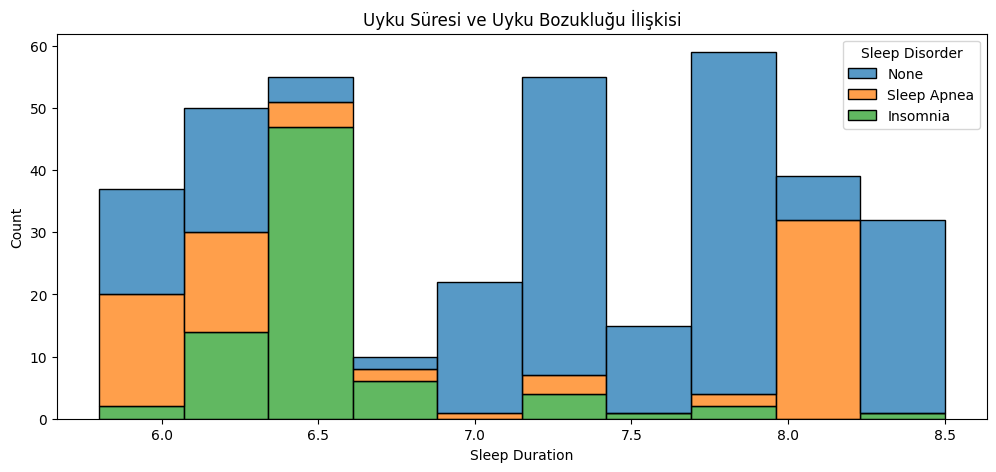

In [37]:
# Görselleştirme: Uyku Süresi ve Kalite Dağılımı
plt.figure(figsize=(12, 5))
sns.histplot(df, x="Sleep Duration", hue="Sleep Disorder", multiple="stack")
plt.title("Uyku Süresi ve Uyku Bozukluğu İlişkisi")
plt.show()

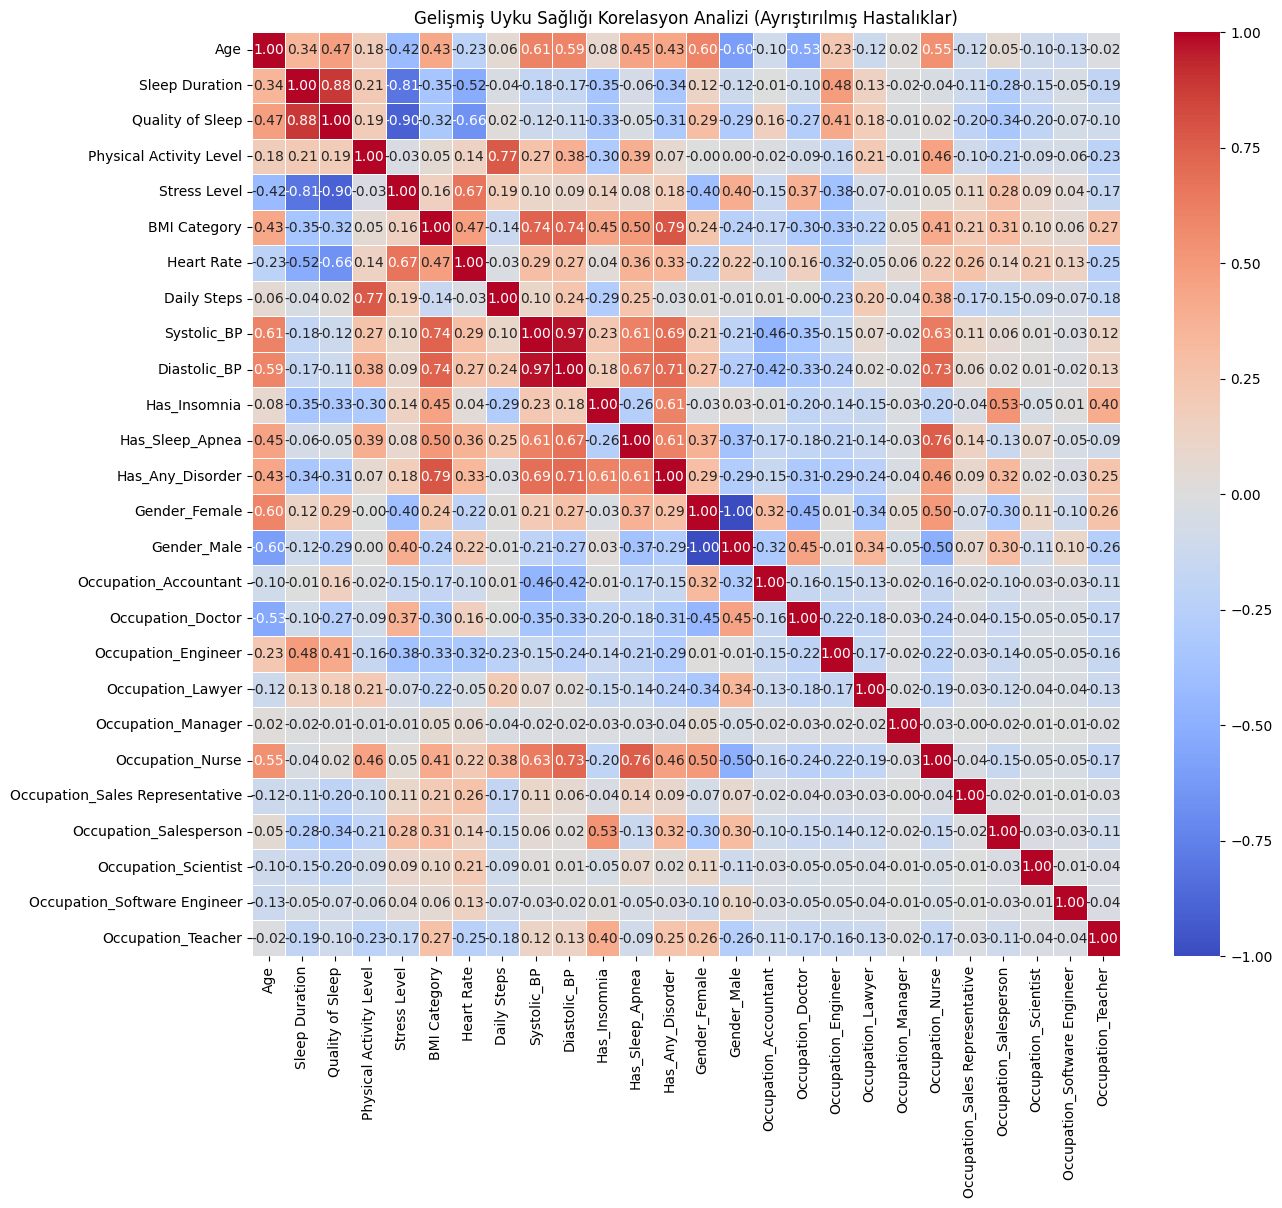


--- INSOMNIA (Uykusuzluk) ile En Güçlü İlişkiler ---
Has_Insomnia                       1.000000
Has_Any_Disorder                   0.605234
Occupation_Salesperson             0.529829
BMI Category                       0.451001
Occupation_Teacher                 0.401501
Systolic_BP                        0.229359
Diastolic_BP                       0.182657
Stress Level                       0.139380
Age                                0.078478
Heart Rate                         0.037201
Gender_Male                        0.027619
Occupation_Software Engineer       0.011345
Occupation_Accountant             -0.013680
Occupation_Manager                -0.026364
Gender_Female                     -0.027619
Occupation_Sales Representative   -0.037335
Occupation_Scientist              -0.052942
Occupation_Engineer               -0.140828
Occupation_Lawyer                 -0.153139
Occupation_Doctor                 -0.195892
Occupation_Nurse                  -0.200700
Has_Sleep_Apnea       

In [38]:
# Gelişmiş Korelasyon Analizi

# Sadece sayısal sütunları seçelim (Sleep Disorder hariç)
numeric_df = df.select_dtypes(include=['int64', 'int32', 'float64', 'int8'])
correlation_matrix = numeric_df.corr()

# Isı Haritası
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Gelişmiş Uyku Sağlığı Korelasyon Analizi (Ayrıştırılmış Hastalıklar)')
plt.show()

# Özel Analiz: Hangi faktörler Insomnia'yı tetikliyor?
print("\n--- INSOMNIA (Uykusuzluk) ile En Güçlü İlişkiler ---")
print(correlation_matrix['Has_Insomnia'].sort_values(ascending=False))

# Özel Analiz: Hangi faktörler Uyku Apnesi'ni tetikliyor?
print("\n--- SLEEP APNEA (Uyku Apnesi) ile En Güçlü İlişkiler ---")
print(correlation_matrix['Has_Sleep_Apnea'].sort_values(ascending=False))

# Özel Analiz: Stres ve Uyku Kalitesi İlişkisi
print("\n--- Stres Seviyesi ve Uyku Kalitesi Arasındaki İlişki ---")
print(f"Korelasyon Katsayısı: {correlation_matrix.loc['Stress Level', 'Quality of Sleep']:.4f}")

## 4. Makine Öğrenmesi ile Modelleme (Machine Learning Modeling)
Bu bölümde, veri setini kullanarak bir **Sınıflandırma Modeli** oluşturacağız. Amacımız, kişinin özelliklerine (Yaş, BMI, Stres vb.) bakarak **Uyku Bozukluğu (Sleep Disorder)** yaşayıp yaşamadığını veya hangi tür bozukluğu olduğunu tahmin etmektir.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Veri Hazırlığı
# Hedef değişkenimiz: 'Sleep Disorder'
# Bu sütun kategorik (None, Insomnia, Sleep Apnea) olduğu için sayısal hale getirmemiz gerekebilir
# Ancak Random Forest genelde label encoding ile çalışabilir.

# Veriyi (X) ve Hedefi (y) belirleyelim
# Not: 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder' sütunlarını FEATURES'tan çıkarmalıyız.
# Çünkü bunlar doğrudan cevabı içeriyor (Data Leakage).
X = df.drop(columns=['Sleep Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder'])

# Hedef
y = df['Sleep Disorder']

# Split Data (Eğitim %80 - Test %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (299, 23)
Test seti boyutu: (75, 23)


In [40]:
# Random Forest Sınıflandırıcısı Kurulumu ve Eğitimi
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred = rf_model.predict(X_test)

print("Model Eğitimi Tamamlandı.")

Model Eğitimi Tamamlandı.


### Model Performans Değerlendirmesi
Modelin **Doğruluk (Accuracy)** skorunu, **Karışıklık Matrisini (Confusion Matrix)** ve detaylı **Sınıflandırma Raporunu** inceleyelim.

Model Doğruluk Oranı (Accuracy): 88.00%
Sınıflandırma Raporu:
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



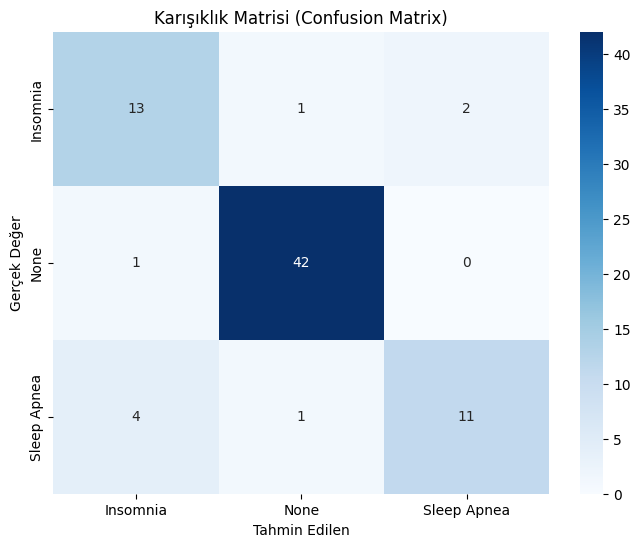

In [41]:
# 1. Doğruluk Skoru
acc = accuracy_score(y_test, y_pred)
print(f"Model Doğruluk Oranı (Accuracy): {acc:.2%}")

# 2. Sınıflandırma Raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# 3. Karışıklık Matrisi Görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Karışıklık Matrisi (Confusion Matrix)')
plt.show()

### Özellik Önem Düzeyleri (Feature Importance)
Hangi faktörün uyku bozukluğu tahmininde daha etkili olduğunu görelim.

/var/folders/dg/z5xrss453fx9b_105ggbyg880000gn/T/ipykernel_11075/2592375325.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


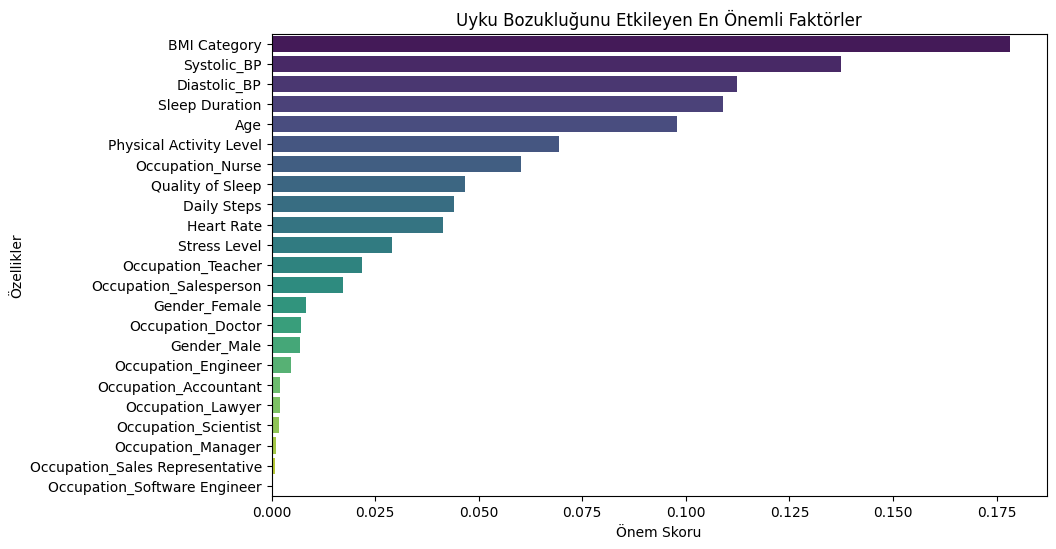

In [42]:
# Özellik Önemlerini Görselleştirme
import pandas as pd

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.title('Uyku Bozukluğunu Etkileyen En Önemli Faktörler')
plt.show()

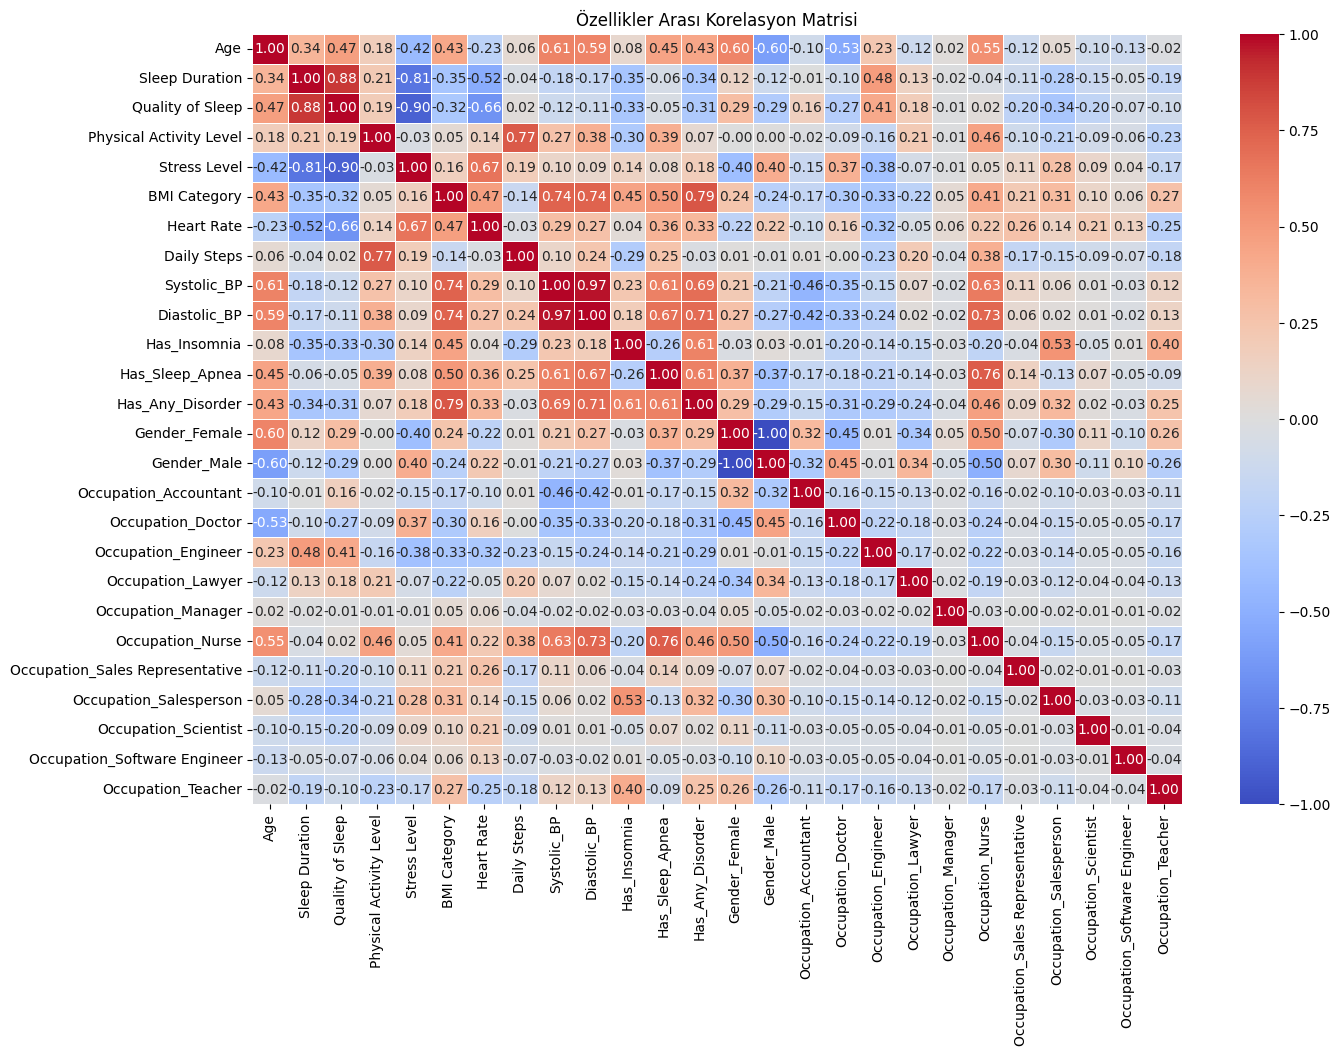


Uyku Bozukluğu Göstergesi (Has_Any_Disorder) ile Korelasyonlar:
Has_Any_Disorder                   1.000000
BMI Category                       0.785389
Diastolic_BP                       0.705025
Systolic_BP                        0.692480
Has_Sleep_Apnea                    0.610180
Has_Insomnia                       0.605234
Occupation_Nurse                   0.462127
Age                                0.432007
Heart Rate                         0.330254
Occupation_Salesperson             0.324787
Gender_Female                      0.285824
Occupation_Teacher                 0.253291
Stress Level                       0.181685
Occupation_Sales Representative    0.087156
Physical Activity Level            0.069787
Occupation_Scientist               0.018059
Daily Steps                       -0.026575
Occupation_Software Engineer      -0.034707
Occupation_Manager                -0.043560
Occupation_Accountant             -0.151507
Occupation_Lawyer                 -0.237076
Gender_Male

In [43]:

# --- KORELASYON ANALİZİ ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Sadece sayısal sütunları seçelim
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()

# Uyku Bozukluğu ile en yüksek korelasyona sahip özellikleri görelim
print("\nUyku Bozukluğu Göstergesi (Has_Any_Disorder) ile Korelasyonlar:")
if 'Has_Any_Disorder' in correlation_matrix.columns:
    print(correlation_matrix['Has_Any_Disorder'].sort_values(ascending=False))


In [44]:

# --- MAKİNE ÖĞRENMESİNE HAZIRLIK ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Hedef Değişkeni (Target) Belirleme
le = LabelEncoder()
# Not: df şu an one-hot encoded, ancak 'Sleep Disorder' orijinal string halde duruyor
y = le.fit_transform(df['Sleep Disorder'])
print("Hedef Sınıflar:", list(le.classes_))

# Özellikler (Features) Belirleme
# Hedefle doğrudan ilişkili türetilmiş sütunları çıkarıyoruz (Data Leakage Önleme)
drop_cols = ['Sleep Disorder', 'Has_Insomnia', 'Has_Sleep_Apnea', 'Has_Any_Disorder']
X = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Veriyi Bölme (%80 Eğitim, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nEğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")


Hedef Sınıflar: ['Insomnia', 'None', 'Sleep Apnea']

Eğitim Seti Boyutu: (299, 23)
Test Seti Boyutu: (75, 23)


Model Doğruluğu (Accuracy): 0.88

Sınıflandırma Raporu:
               precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



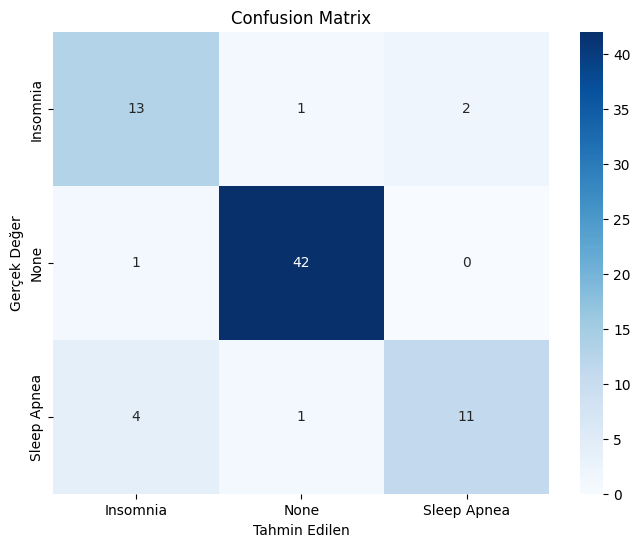

In [45]:

# --- RANDOM FOREST MODEL EĞİTİMİ VE DEĞERLENDİRME ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Tanımlama ve Eğitme
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Tahmin Yapma
y_pred = rf_model.predict(X_test)

# Sonuçlar
print(f"Model Doğruluğu (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Karmaşıklık Matrisi (Confusion Matrix)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')
plt.show()


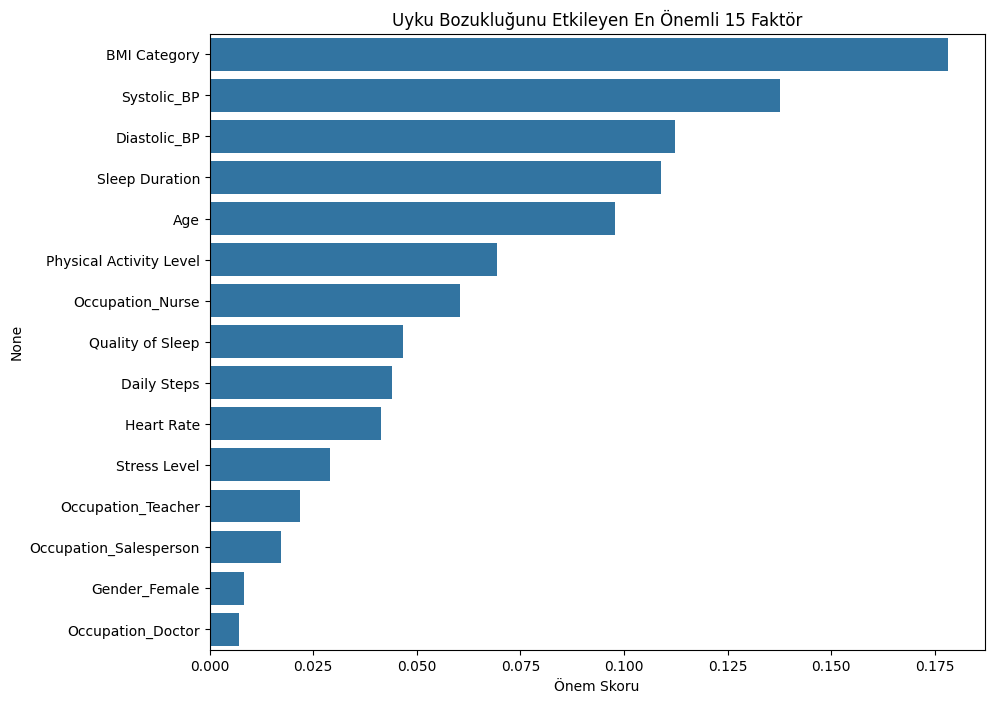

In [46]:

# --- ÖZELLİK ÖNEM DÜZEYLERİ (FEATURE IMPORTANCE) ---
import pandas as pd

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[:15], y=feature_importances.index[:15])
plt.title("Uyku Bozukluğunu Etkileyen En Önemli 15 Faktör")
plt.xlabel("Önem Skoru")
plt.show()
